# Deep Q-Network (DQN)

This notebook is a step-by-step implementation of the Deep Q-Learning Network (DQN) agent that uses a Neural Network (NN) to estimate the action value (Q value) of a state. Deep Q-Learning Network was invented by Google DeepMind in 2013, and it became famous for achieving superhuman performance on 29 out of 49 games on *Atari 2600* games.

The links to DQN papers are at the end in the **References** section.

## Prerequisites

You are expected to have basic familiarity with Machine Learning, Deep Learning, and Reinforcement Learning, especially on following topics:

 * Neural Network
 * Temporal Difference (TD) Learning
 * Q-Learning

You are also expected to have basic familarity with PyTorch, especially on following modules:

 * `torch.nn`
 * `torch.optim`

## Setup

In [1]:
import copy
import random
from collections import deque

import gym
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from IPython.display import clear_output
%matplotlib inline

In [3]:
USE_CUDA = torch.cuda.is_available()

## Environment: CartPole

In this notebook, we use the **CartPole** environment from [OpenAI Gym](https://gym.openai.com). In the CartPole environment, the agent has two components: a cart and a pole.

At every timestep, the agent receives +1 reward unless the episode is terminated. The episode terminates if

 1. the cart is too far left or right
 2. the pole  is too far off from its upright position
 3. 200 timesteps passed.

Thus, the agent's goal is to maintain balance so that the pole stays upright. To maintain balance, the agent must move the cart left or right accordingly.

![Cartpole](cartpole.gif)

In [4]:
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [5]:
print('Observation Space: ', env.observation_space)
print('Action Space: ', env.action_space)

Observation Space:  Box(4,)
Action Space:  Discrete(2)


**State Space Dimensions**: 4
 * $x$: Location of the cart
 * $x'$: Speed of the cart
 * $\theta$: Angle of the pole
 * $\theta'$: Angular Speed of the pole

**Action Space Size**: 2
 * Left
 * Right

**Reward**: +1 for all state

## Deep Q-Network (DQN)

Deep Q-Network (DQN) is a neural network that approximates the action-value of each action given a state. For the DQN, we will use a simple neural network with few fully connected layers. The input will be the observation $s=(x, x', \theta, \theta')$, and the output will be the action values $Q(s, \text{left})$ and $Q(s, \text{right})$.

In PyTorch, we create a new neural network class by inheriting `torch.nn.Module`. We define the layers in `.__init__()` and define the forward propagation step in `.forward()`. PyTorch takes care of the backpropagation step.

In [8]:
class DQN(nn.Module):
    """
    A simple Deep Q-Network with fully connected layers.
    """
    def __init__(self, input_dims, output_dims):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dims, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dims)
        )

    def forward(self, x):
        return self.layers(x)

## Replay Buffer

In Q-Learning, the agent only looks at each experience once: after taking an action, it uses the experience $(s, a, r, s')$ once and forgets it immediately after the update. **Experience Replay** considers a different approach: the agent remembers the last $D$ experiences by saving them into a "replay memory". Also, instead of updating the parameters with the new experience, the agent updates its parameters by sampling a batch from the replay memory.

This approach has several advantages:

 1. Every experience is used multiple times, so it is more efficient in terms of data.
 2. Experiences are strongly correlated in the Naive DQN. Randomly sampling from replay memory breaks these correlations and thus reduces the variance of the updates.

To implement experience replay, we create a `ReplayBuffer` class. The `ReplayBuffer` needs two functions:

 * `ReplayBuffer.append()` that appends the new experience
 * `ReplayBuffer.sample()` that uniformly samples a batch of experiences from the buffer

We will use Python's `deque` (pronounced "deck", not "dequeue").

In [9]:
class ReplayBuffer:
    """
    A buffer that stores experiences for experience replay.
    """
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, state, action, reward, next_state, done):
        """
        Append given experience to the buffer.
        
        Parameters
        ----------
        state : list of float
            The current state s given by the environment.
        action : int
            Action a chosen by the agent.
        reward : float
            Reward given by the environment for given state s and action a.
        next_state : list of float
            The resulting state s' after taking action a on state s.
        done: bool
            True if the episode has terminated.
        """
        state      = np.expand_dims(state, axis=0)
        next_state = np.expand_dims(next_state, axis=0)

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """
        Uniformly sample a batch from the buffer.

        Parameters
        ----------
        batch_size : int
            The size of the batch to sample.

        Returns
        -------
        batch : tuple
            The batch of samples.
        """
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

<div class="alert alert-warning">
Note that `deque` automatically discards the leftmost (first-in) element if it is full.
</div>

## Agent

The `DQNAgent` class is quite long, so let's look at each function separately. It has 8 functions:

 * `__init__`
 * `act`
 * `_compute_td_loss`
 * `_update_parameters`
 * `_update_target`
 * `_plot`
 * `train`
 * `play`

### `__init__`

In the `__init__`, we save the parameters into `self`. These are the parameters:

 * `env`: The environment
 * `dqn`: The Deep Q-Network model
 * `optimizer`: The optimizer to use for updating weights of `dqn`
 * `epsilon_schedule`: A function that given a timestep returns `epsilon`
 * `replay_buffer`: An instance of a `ReplayBuffer`
 * `discount_factor`: The discount factor $\gamma$
 * `target_update_rate`: Frequency of updating the target network.
 * `batch_size`: The size of batch sampled from the replay buffer
 * `replay_start_size`: The minimum size of replay buffer before starting to train

In [10]:
class DQNAgent:
    """
    A reinforcement learning agent that uses DQN specified by DeepMind's 2015
    paper to estimate action values.
    """
    def __init__(self, env, dqn,
                 optimizer,
                 epsilon_schedule,
                 replay_buffer,
                 discount_factor=0.99,
                 target_update_rate=10000,
                 batch_size=32,
                 learn_start=32):
        self.env = env
        self.dqn = dqn
        self.target_dqn = copy.deepcopy(dqn)
        self.optimizer = optimizer
        self.epsilon_schedule = epsilon_schedule
        self.replay_buffer = replay_buffer
        self.discount_factor = discount_factor
        self.target_update_rate = target_update_rate
        self.batch_size = batch_size
        self.learn_start = learn_start

### `act`

The `act` function returns an action selected $\epsilon$-greedily, given a state and an epsilon $\epsilon$.

In [11]:
def act(self, state, epsilon):
    """
    Return an action with respect to the epsilon-greedy policy.

    Parameters
    ----------
    state : list of float
        The current state given by the environment.
    epsilon : float
        The possibility of selecting a random action.

    Returns
    -------
    action : int
        The action chosen by the agent.
    """
    if random.random() > epsilon:
        state = torch.FloatTensor(state)
        q_values = self.dqn(state)
        action = q_values.argmax().item()
    else:
        action = self.env.action_space.sample()
    return action

### `_compute_loss`

To compute the loss of a batch of experience, we define `_compute_loss()` function.

In [12]:
def _compute_loss(self):
    """
    Compute the MSE loss given a transition (s, a, r, s').

    Parameters
    ----------
    state : list of float
        The current state s given by the environment.
    action : int
        Action a chosen by the agent.
    reward : float
        Reward given by the environment for given state s and action a.
    next_state : list of float
        The resulting state s' after taking action a on state s.
    done: bool
        True if the episode has terminated.

    Returns
    -------
    loss : torch.tensor
        The MSE loss of the DQN.
    """
    state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)

    state      = torch.FloatTensor(state)
    next_state = torch.FloatTensor(next_state)
    action     = torch.LongTensor(action)
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(done)

    q_values = self.dqn(state)
    q_value  = q_values.gather(1, action.unsqueeze(1)).squeeze(1)

    next_q_values = self.target_dqn(next_state)
    next_q_value  = next_q_values.max(1)[0]
    target = reward + self.discount_factor * next_q_value * (1 - done)

#     loss = F.smooth_l1_loss(q_value, target.detach())
    loss = F.mse_loss(q_value, target.detach())

    return loss

<div class='alert alert-warning'>
To adhere to the DeepMind paper example, we should use the Huber Loss (also known as the Smooth L1 Loss), but MSE loss gives better result in CartPole where reward is always +1.
</div>

### `_update_parameters`

The `_update_parameters` function updates the parameters of the DQN with the loss calculated in `_compute_loss`.

In PyTorch, the method of updating weights is standardized.

 1. `self.optimizer.zero_grad()`: Set the gradients to zero.
 2. `loss.backward()`: Perform backpropagation to calculate the gradients.
 3. `self.optimizer.step()`: Use the calculated gradients to update the weights.

In [13]:
def _update_parameters(self, loss):
    """
    Update parameters with the given loss.

    Parameters
    ----------
    loss
        The temporal difference loss of Q Learning.
    """
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

<div class='alert alert-warning'>
When `loss.backward()` is called, the stored gradients for each parameter are updated by adding the new gradients. Therefore, the gradients should be set to zero every time before calculating the gradients.
</div>

### `_update_target`

**Target Network** $\hat{Q}$ is a method of using a separate network to generate the target $r + \gamma \max_{a'} \hat{Q}(s', a')$. The target network $\hat{Q}$ is updated periodically by cloning the parameters of the original network $Q$.

In PyTorch, you can retrieve the weights of a model with `.state_dict()` and assign weights to a model with `.load_state_dict()`.

In [14]:
def _update_target(self):
    """
    Update the target network's weights with that of the update network.
    """
    self.target_dqn.load_state_dict(self.dqn.state_dict())

### `_plot`

The `_plot` function simply plots the episode reward, losses, and epsilons using `matplotlib`.

In [15]:
def _plot(self, rewards, losses, epsilons):
    """
    Plot the total episode rewards and losses per timestep.

    Parameters
    ----------
    rewards : list of float
        List of total rewards for each episode.
    losses : list of float
        List of losses for each timestep.
    epsilons : list of float
        List of epsilons for each timestep.
    """
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Episodic Reward')
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('TD Loss')
    plt.plot(losses)
    plt.subplot(133)
    plt.title('Epsilon')
    plt.plot(epsilons)
    plt.tight_layout()
    plt.show()

### `train`

The `train` function is function that uses all the functions defined above. At every timestep, the agent:

 1. Choose an action with the DQN
 2. Receive (state, reward, done, info) from the environment and adds it to the replay buffer
 3. Sample a batch from the replay buffer
 4. Calculate the loss from the batch
 5. Update the parameters with the batch
 6. Update the target DQN if needed
 7. If the episode is finished, reset environment.

In [16]:
def train(self, n_steps=5000):
    """
    Train the agent for specified number of steps.

    Parameters
    ----------
    n_steps : int
        Number of timesteps to train the agent for.
    """
    all_rewards = []
    losses = []
    epsilons = []
    episode_reward = 0

    state = self.env.reset()
    for frame_idx in range(1, n_steps + 1):

        epsilon = self.epsilon_schedule(frame_idx)
        epsilons.append(epsilon)
        action = self.act(state, epsilon)
        next_state, reward, done, _ = self.env.step(action)
        episode_reward += reward
        self.replay_buffer.append(state, action, reward, next_state, done)

        if len(self.replay_buffer) >= self.learn_start:
            loss = self._compute_loss()
            self._update_parameters(loss)
            losses.append(loss.item())

        if done:
            state = self.env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        if frame_idx % self.target_update_rate == 0:
            self._update_target()

        state = next_state

        if frame_idx % 200 == 0:
            self._plot(all_rewards, losses, epsilons)

### `play`

In the `play` function, we run the episode once with $\epsilon = 0$ (i.e. greedy).

In [17]:
def play(self, render=True):
    """
    Play an episode and return the total reward for the episode.

    Parameters
    ----------
    render : bool
        If true, render the environment.
    """
    done = False
    state = self.env.reset()
    total_reward = 0
    while not done:
        action = self.act(state, epsilon=0)
        next_state, reward, done, _ = self.env.step(action)
        if render:
            self.env.render()
        total_reward += reward
        state = next_state

    return total_reward

Let's add all these functions the `DQNAgent` to see how our implementation performs in `CartPole`.

In [18]:
DQNAgent.act = act
DQNAgent._compute_loss = _compute_loss
DQNAgent._update_parameters = _update_parameters
DQNAgent._update_target = _update_target
DQNAgent._plot = _plot
DQNAgent.train = train
DQNAgent.play = play

## Epsilon Decay

We need to create a function `epsilon_schedule` that returns an epsilon value for every timestep. We implement ` get_epsilon_schedule` an `epsilon_schedule` function that linearly anneals $\epsilon$ for $N$ steps.

$$ \epsilon_i = \epsilon_\text{End} + \max \left( 0, \frac{(\epsilon_\text{Start} - \epsilon_\text{End}) (N - \max(0, i - C))}{N} \right) $$

where $C$ is the step that the agent starts training.

In [19]:
def get_epsilon_schedule(start, end, endt, learn_start):
    """
    Generate a decreasing function that returns epsilon for each timestep.

    Parameters
    ----------
    start : float
        The epsilon value for step 0.
    end : float
        The epsilon value for step n.
    endt : int
        The number of timesteps to linearly anneal the epsilon.
    learn_start : int
        The step that the learning begins. Should be equal to DQNAgent's
        learn_start.

    Returns
    -------
    object
        A function that returns epsilon for each timestep.
    """
    return lambda step: end + max(0, (start - end) *
                                  (endt - max(0, step - learn_start)) / endt)

Let's plot the epsilon schedule for a sanity check.

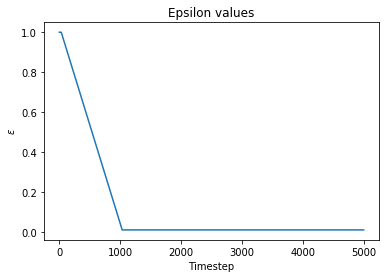

In [20]:
epsilon_schedule = get_epsilon_schedule(start=1.0, end=0.01, endt=1000, 
                                        learn_start=32)
steps = np.arange(5000)
epsilons = [epsilon_schedule(step) for step in steps]
plt.title('Epsilon values')
plt.xlabel('Timestep')
plt.ylabel('$\\epsilon$')
plt.plot(steps, epsilons)

## Result

For the hyperparameters, we mostly used the hyperparameters provided by the 2015 DQN paper, but used smaller values for hyperparameters related to total number of steps. For reference, below are the original hyperparameters:

![Hyperparameters for Atari 2600](hyperparameters.png)

In [21]:
dqn = DQN(env.observation_space.shape[0], env.action_space.n)
if USE_CUDA:
    dqn = dqn.cuda()
optimizer        = optim.RMSprop(dqn.parameters(), 
                                   lr=0.00025,
                                   momentum=0.95,
                                   alpha=0.95,
                                   eps=0.01)
epsilon_schedule = get_epsilon_schedule(start=1.0,
                                          end=0.01,
                                          endt=1000,
                                          learn_start=50)
replay_buffer    = ReplayBuffer(capacity=1000)
agent = DQNAgent(env, dqn, optimizer, epsilon_schedule, replay_buffer,
                 discount_factor=0.99,
                 target_update_rate=10,
                 batch_size=32,
                 learn_start=50)

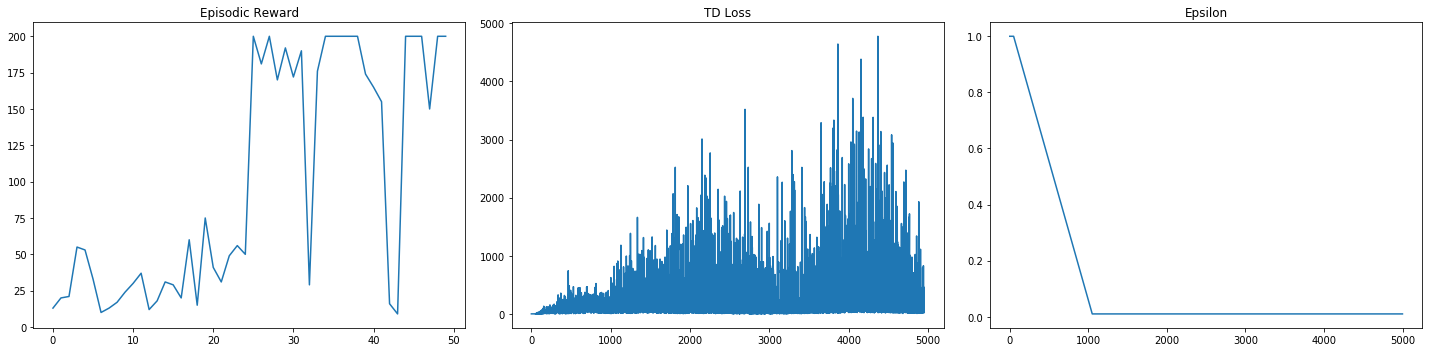

In [22]:
agent.train(5000)

In [23]:
total_reward = agent.play()
print('Total Reward: {}'.format(total_reward))

Total Reward: 200.0


In [24]:
agent.env.close()

<div class='alert alert-warning'>
You can close the rendered environment with `agent.env.close()`. However, this also destroys the environment. Check [this GitHub issue](https://github.com/openai/gym/issues/878) for details.
</div>

## References

### Papers

 * [Playing Atari with Deep Reinforcement Learning (2013)](https://arxiv.org/pdf/1312.5602.pdf)
 * [Human-level control through deep reinforcement learning (2015)](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf)

### Posts

 * [Let's Build an Atari AI](https://becominghuman.ai/lets-build-an-atari-ai-part-1-dqn-df57e8ff3b26)

### Code

 * [DeepMind's DQN with Lua](https://github.com/deepmind/dqn)
 * [higgsfield's RL Adventure with PyTorch](https://github.com/higgsfield/RL-Adventure)